This work has been done by Raphael Faure (raphael.faure@student-cs.fr)

# Modules

In [ ]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-nyg89drl
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-nyg89drl
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 7.6 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7771 sha256=d792391ba83a7e325eeb17d2a67353bd2fe381e64494eed8f852b78dec1a98dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-08jmzquy/wheels/a1/07/d2/74e9570f22696f6a81089c4e5dbe11248ff1e4b3236dafe59d
Successfully built text-flappy-bird-gym
  Attempting uninstall: gymnasium
    Found existing installation: gymn

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 5.9 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
import gym
import sys
import torch
import optuna



In [ ]:
# initiate environment
import os, sys
import gymnasium as gym
import time

import text_flappy_bird_gym
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
env.close()

In [ ]:
print(env.observation_space)
print(env.action_space)

# Agent and environment

Tuple(Discrete(14), Discrete(22, start=-11))
Discrete(2)


In [ ]:
"""An abstract class as we did durings the labs.
"""

from __future__ import print_function
from abc import ABCMeta, abstractmethod


class BaseAgent:
    """Implements the agent for an RL-Glue environment.
    Note:
        agent_init, agent_start, agent_step, agent_end, agent_cleanup, and
        agent_message are required methods.
    """

    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @abstractmethod
    def agent_init(self, agent_info= {}):
        """Setup for the agent called when the experiment first starts."""

    @abstractmethod
    def agent_start(self, observation):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

    @abstractmethod
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

    @abstractmethod
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """

    @abstractmethod
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""

    @abstractmethod
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """


# Some functions for training and working with agents

In [ ]:
import numpy as np
import torch
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
from tqdm import tqdm
from IPython.display import clear_output


def episode(agent, env, num_states_x, num_states_y, num_actions):
    """
    Runs a single episode in the given environment using the provided agent.

    Parameters:
        agent (BaseAgent): The agent with agent_start, agent_step, and agent_end methods.
        env (gym.Env): The environment following the OpenAI Gym API.
        num_states_x (int): Number of discrete states for dx.
        num_states_y (int): Number of discrete states for dy.
        num_actions (int): Number of possible actions in the environment.

    Returns:
        visited_states (Tensor): A (num_states_x x num_states_y) tensor counting state visits.
        chosen_action (list): List of actions taken during the episode.
        sum_rewards (float): Cumulative reward collected in the episode.
        score (int): Final score returned by the environment (e.g. number of pipes passed).
    """
    visited_states, chosen_action = torch.zeros(num_states_x, num_states_y), []
    sum_rewards = 0
    observation = env.reset()
    action = agent.agent_start(list(observation[0]))
    done = False
    score = 0

    while True:
        d = env.step(action)
        state = list(d[0])
        reward, done = d[1], d[2]
        score = d[-1]['score']

        visited_states[state[0], state[1]] += 1
        sum_rewards += reward

        if done:
            agent.agent_end(reward)
            break
        else:
            action = agent.agent_step(reward, state)
            chosen_action.append(action)

    return visited_states, chosen_action, sum_rewards, score


def train(config, method, method_name, env, save = False, N_ep = 15000, name = 'agent'):
    """
    Trains an agent using the given method on the specified environment.

    Parameters:
        config (dict): Dictionary containing agent initialization parameters.
        method (class): Agent class to instantiate (e.g., SarsaLambdaAgent, MonteCarloAgent).
        method_name (str): Name of the method (used for labeling plots).
        env (gym.Env): Environment in which the agent will be trained.
        save (bool, optional): Whether to return the trained agent after training. Default is False.
        N_ep (int, optional): Number of episodes to train the agent for. Default is 15,000.

    Returns:
        agent (BaseAgent, optional): The trained agent, returned only if save=True.
    """
    agent = method()
    agent.agent_init(config)
    nums_episode = N_ep
    all_reward_sums = []
    all_scores = []
    times = []

    N = 500  # interval for timing

    for ep in tqdm(range(nums_episode)):
        if ep % N == 0:
            start_time = time.time()

        state_visits, chosen_actions, mean_rewards, score = episode(
            agent, env,
            num_actions=config["num_actions"],
            num_states_x=config["num_states_x"],
            num_states_y=config["num_states_y"]
        )

        all_reward_sums.append(mean_rewards)
        all_scores.append(score)

        if (ep + 1) % N == 0:
            end_time = time.time()
            avg_time = (end_time - start_time) / N
            times.append(avg_time)

    final_state_visits, _, _, _ = episode(agent, env, num_actions=config["num_actions"], num_states_x=config["num_states_x"], num_states_y=config["num_states_y"])
    run_demo(agent, env)

    torch.save(agent.q, f"{name}_Q.pt")

    plot_metric_over_ep(np.array(all_reward_sums), np.array(all_scores), times, method_name, agent=agent, env=env)

    if save:

        return agent



def plot_metric_over_ep(rewards, scores, times, method="Sarsa", agent=None, env=None):
    """
    Plot training metrics over episodes, including smoothed rewards
    and time per block of episodes.

    Parameters:
        rewards (np.ndarray): Total rewards per episode.
        scores (np.ndarray): Unused here.
        times (list of float): Average time per block of episodes.
        method (str): Name of the RL method (used for plot labels).
        agent (BaseAgent): Unused.
        env (gym.Env): Unused.
    """
    fig = plt.figure(figsize=(12, 4))
    window_size = 100

    # Plot rewards
    ax1 = fig.add_subplot(1, 2, 1)
    moving_avg_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    ax1.plot(moving_avg_rewards, label=f"{method} Rewards (moving avg)")
    ax1.set_title("Smoothed Rewards per Episode")
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Sum of rewards")
    ax1.legend()

    # Plot time per block
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(times, label=f"{method} Avg Time per block")
    ax2.set_title("Time per block of episodes")
    ax2.set_xlabel(f"Blocks of {len(rewards) // len(times)} episodes")
    ax2.set_ylabel("Time (s)")
    ax2.legend()

    plt.tight_layout()
    plt.show()





def run_demo(agent, env):
    """
    Runs a visual demonstration of the trained agent in the environment.
    Displays the game rendering in the console.
    """
    state = env.reset()[0]
    done = False
    total_reward = 0
    agent.freeze = True
    print("\n==== Agent Demo ====")

    action = agent.agent_start(list(state))
    while not done:
        clear_output(wait=True)
        sys.stdout.write(env.render())
        time.sleep(0.1)

        obs, reward, done, _, info = env.step(action)
        total_reward += reward
        state = list(obs)
        print(state)
        if done:
            agent.agent_end(reward)
            break
        else:
            action = agent.agent_step(reward, state)

    agent.freeze = False
    print("Total reward from demo:", total_reward)



def test(agent, env, num_episodes=5):
    for i in range(num_episodes):
        print(f"Demo Episode {i+1}")
        run_demo(agent, env)
        input("Press Enter to continue to next episode...")

def clip_state(state, max_x, max_y):
    """
    Clips the state to remain within the valid encoded index range,
    with special handling for dy ∈ [-11, 10] mapped to [0, 21].

    Parameters:
        state (tuple): (dy, dx) from environment
        max_x (int): number of discrete values for dx (e.g., 15)
        max_y (int): number of discrete values for dy (e.g., 22)

    Returns:
        (int, int): clipped and encoded state as (dy_index, dx)
    """
    dy, dx = state

    # Clip dx to [0, max_x - 1]
    dx = min(max(dx, 0), max_x - 1)

    # Clip dy to [-11, 10] before mapping
    dy = min(max(dy, -11), 10)

    # Encode dy ∈ [-11, 10] → [0, 21]
    dy_index = 22 + dy if dy < 0 else dy

    return dy_index, dx


def load_agent_from_q(path, agent_class, base_config):
    q_tensor = torch.load(path)
    config = base_config.copy()
    config["num_states_x"], config["num_states_y"], config["num_actions"] = q_tensor.shape
    agent = agent_class()
    agent.agent_init(config)
    agent.q = q_tensor.clone()
    agent.freeze = True
    return agent



In [ ]:
def plot_state_value(agent, normalize=False):
    """
    Plots the state-value function V(s) = max_a Q(s,a) with corrected dy mapping.

    Parameters:
        agent (BaseAgent): The agent with a learned Q-table.
        normalize (bool): Whether to plot normalized values.
    """
    assert hasattr(agent, "q")

    with torch.no_grad():
        q = agent.q.cpu().numpy()  # shape: [dx, dy_encoded, actions]
        state_value = np.max(q, axis=2)  # shape: [dx, dy_encoded]

        if normalize:
            state_value = state_value / np.max(state_value)

    # Build mapping from true dy ∈ [-11, 10] to encoded index i
    dy_true = list(range(-11, 11))  # 22 values
    index_map = [22 + dy if dy < 0 else dy for dy in dy_true]  # inverse mapping

    # Reorder the state_value rows to match increasing dy
    reordered_state_value = state_value[: , index_map]

    plt.figure(figsize=(7, 6))
    sns.heatmap(reordered_state_value.T, cmap="viridis", cbar=True,
                xticklabels=list(range(agent.num_states_x)),
                yticklabels=[-k for k in range(-11,11)])
    plt.xlabel("dX (0 → 14)")
    plt.ylabel("dY (-11 → 10)")
    plt.title("Normalized State-Value Function" if normalize else "State-Value Function")
    plt.tight_layout()
    plt.show()


Due to a mismatch in coordinate encoding, the state-value heatmap initially displayed alongside the learning curve is misaligned and should be disregarded. The corrected heatmap presented later with plot_state_value() reflects the true structure of the learned value function. I didn't have time to run again the script after fixing that. Also there were some issues with the run_demo() function at the beginning so the demo displayed above the plots should be also disregarded.


# Sarsa based agent

In [ ]:
class SarsaLambdaAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the Sarsa(λ) agent."""
        self.num_actions = agent_init_info["num_actions"]
        self.num_states_x = agent_init_info["num_states_x"] # number of values for dx
        self.num_states_y = agent_init_info["num_states_y"] # number of values for dy
        self.epsilon = agent_init_info["epsilon"]
        self.epsilon_min = agent_init_info["epsilon_min"]
        self.epsilon_decay = agent_init_info["epsilon_decay"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.lmbda = agent_init_info["lambda"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.freeze = False #to test the agent over differents env without learning
        self.diff_env = False #to test the agent over differents config
        # Q-values table
        self.q = torch.zeros([self.num_states_x, self.num_states_y, self.num_actions]) # shape: [dx, dy, num_actions]
        # Eligibility traces table
        self.e = torch.zeros_like(self.q)

    def agent_start(self, state):
        """Called at the beginning of an episode."""
        if self.diff_env:
          state = clip_state(state, self.num_states_x, self.num_states_y)
        q_values = self.q[state[0], state[1], :].numpy()
        if self.freeze :
          action = self.argmax(q_values)
        else :
          if self.rand_generator.rand() < self.epsilon:
              action = self.rand_generator.randint(self.num_actions)
          else:
              action = self.argmax(q_values)
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.prev_state = state
        self.prev_action = action
        self.e.zero_()  # Reset eligibility traces at start of episode
        return action

    def agent_step(self, reward, state):
        """Sarsa(λ) step with eligibility traces."""
        # Epsilon-greedy for next action
        if self.diff_env :
          state = clip_state(state, self.num_states_x, self.num_states_y)
        q_values = self.q[state[0], state[1], :].numpy()
        if self.freeze :
          action = self.argmax(q_values)
        else :
          if self.rand_generator.rand() < self.epsilon:
              action = self.rand_generator.randint(self.num_actions)
          else:
              action = self.argmax(q_values)
        if self.freeze:
          self.prev_state = state
          self.prev_action = action
          return action
        else:
          # Compute TD error δ
          delta = reward + self.discount * self.q[state[0], state[1], action] - self.q[self.prev_state[0], self.prev_state[1], self.prev_action]

          # Update eligibility trace for (S_t, A_t)
          self.e[self.prev_state[0], self.prev_state[1], self.prev_action] += 1.0

          # Update all Q-values and decay eligibility traces
          self.q += self.step_size * delta * self.e
          self.e *= self.discount * self.lmbda
          self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
          self.prev_state = state
          self.prev_action = action
          return action

    def agent_end(self, reward):
        """Sarsa(λ) update at terminal state."""
        if self.freeze :
          pass
        else :
          delta = reward - self.q[self.prev_state[0], self.prev_state[1], self.prev_action]
          self.e[self.prev_state[0], self.prev_state[1], self.prev_action] += 1.0
          self.q += self.step_size * delta * self.e
          self.e *= self.discount * self.lmbda

    def argmax(self, q_values):
        """argmax with random tie-breaking."""
        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)


Text Flappy Bird!
Score: 0
----------------------
[       |         |  ]
[       |         |  ]
[       |         |  ]
[      @|         |  ]
[       |         |  ]
[       |         |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=1,dy=-5)
Total reward from demo: 13


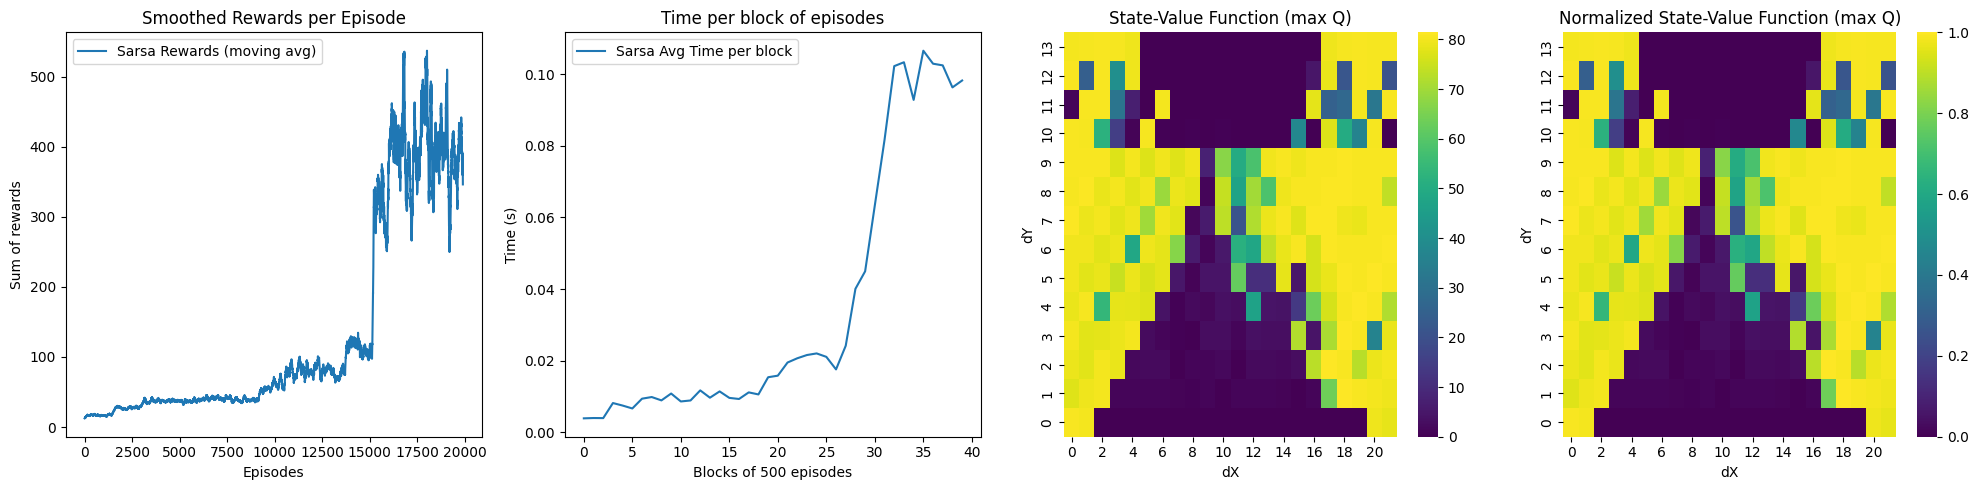

In [ ]:
import text_flappy_bird_gym
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
agent_info = {"num_actions": 2, "num_states_x": 14, "num_states_y": 22, "epsilon": 0.85, "epsilon_min" : 1e-2, "lambda":0.8, "epsilon_decay" : 0.999, "step_size": 0.05, "discount": 0.99, "seed":1}
train(agent_info, SarsaLambdaAgent, "Sarsa", env, N_ep = 20000, name = 'sarsa_agent_20000_steps' )

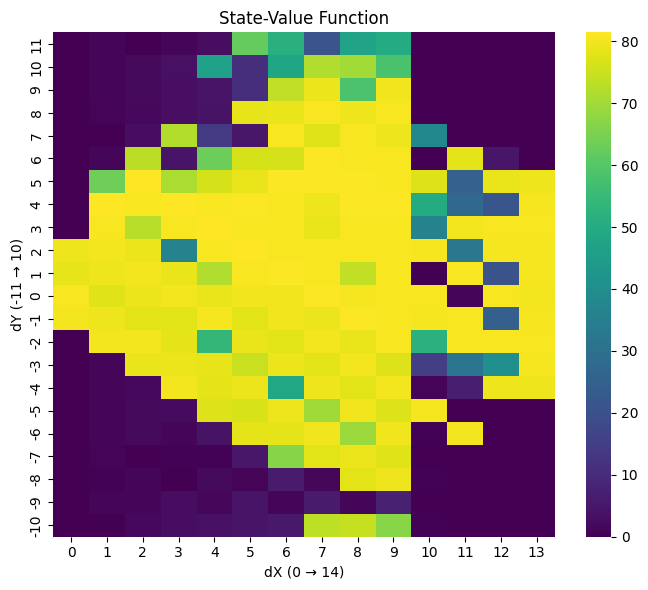

In [ ]:
agent_info = {"num_actions": 2, "num_states_x": 14, "num_states_y": 22,  "epsilon": 0.0, "epsilon_min" : 5e-3, "lambda":0.8, "epsilon_decay" : 0.99,'step_size': 0.4151478230492108, "discount": 0.99, "seed":1}
sarsa_agent = load_agent_from_q('/content/sarsa_agent_20000_steps_Q.pt', SarsaLambdaAgent, agent_info)
plot_state_value(sarsa_agent, normalize=False)

# Monte Carlo based agent

In [ ]:

class MonteCarloAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """
        Initialize the Monte Carlo agent.

        Expected keys in agent_init_info (dict):
            - num_states_x (int): number of discrete states for dx.
            - num_states_y (int): number of discrete states for dy.
            - num_actions (int): number of possible actions.
            - epsilon (float): epsilon parameter for exploration.
            - step_size (float): learning rate (alpha).
            - discount (float): discount factor (gamma).
            - seed (int): random seed for reproducibility.
        """
        self.num_actions = agent_init_info["num_actions"]
        self.num_states_x = agent_init_info["num_states_x"]
        self.num_states_y = agent_init_info["num_states_y"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.epsilon_min = agent_init_info["epsilon_min"]
        self.epsilon_decay = agent_init_info["epsilon_decay"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.freeze = False #to test the agent over differents env without learning
        self.diff_env = False #to test the agent over differents config

        # Q-value table initialized to zero
        self.q = torch.zeros([self.num_states_x, self.num_states_y, self.num_actions])

        # Buffer to store the current episode's trajectory
        # Each element is a tuple: (state, action, reward)
        self.episode = []

    def agent_start(self, state):
        """
        Called at the beginning of an episode.
        Selects the first action using an epsilon-greedy policy,
        and initializes the episode buffer.
        """
        if self.freeze:
            if self.diff_env :
              state = clip_state(state, self.num_states_x, self.num_states_y)
            # Get Q-values for the initial state
            q_values = self.q[state[0], state[1], :].numpy()
            action = self.argmax(q_values)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            return action
        else:
            q_values = self.q[state[0], state[1], :].numpy()
            if self.rand_generator.rand() < self.epsilon:
                action = self.rand_generator.randint(self.num_actions)
            else:
                action = self.argmax(q_values)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            # Start the episode buffer with the initial state-action pair
            self.episode = [(state, action, 0.0)]
            return action

    def agent_step(self, reward, state):
        """
        Called at each non-terminal step.
        Updates the previous transition with the received reward,
        selects the next action using epsilon-greedy,
        and appends the new transition to the episode buffer.
        """
        if self.freeze:
            if self.diff_env :
              state = clip_state(state, self.num_states_x, self.num_states_y)
            q_values = self.q[state[0], state[1], :].numpy()
            action = self.argmax(q_values)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            return action
        else:
            # Update reward of the last transition
            last_state, last_action, _ = self.episode[-1]
            self.episode[-1] = (last_state, last_action, reward)

            # Select next action using epsilon-greedy
            q_values = self.q[state[0], state[1], :].numpy()
            if self.rand_generator.rand() < self.epsilon:
                action = self.rand_generator.randint(self.num_actions)
            else:
                action = self.argmax(q_values)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            # Add the new state-action pair to the buffer (reward will be updated next step)
            self.episode.append((state, action, 0.0))

            return action

    def agent_end(self, reward):
        """
        Called at the end of an episode.
        Updates the last transition with the terminal reward,
        computes the return G for each state-action pair,
        and performs incremental Monte Carlo Q-value updates.
        """
        if self.freeze:
            pass
        else:
            # Update the last transition with the final reward
            last_state, last_action, _ = self.episode[-1]
            self.episode[-1] = (last_state, last_action, reward)

            # Compute the return G for each transition
            G = 0.0
            # Traverse the episode in reverse
            for t in reversed(range(len(self.episode))):
                state, action, reward = self.episode[t]
                G = reward + self.discount * G
                # Incremental MC update
                self.q[state[0], state[1], action] += self.step_size * (G - self.q[state[0], state[1], action])

            # Clear the episode buffer
            self.episode = []

    def argmax(self, q_values):
        """
        Returns the index of the maximum value in q_values,
        with random tie-breaking in case of equality.
        """
        top_value = float("-inf")
        ties = []
        for i, value in enumerate(q_values):
            if value > top_value:
                top_value = value
                ties = [i]
            elif value == top_value:
                ties.append(i)
        return self.rand_generator.choice(ties)



Text Flappy Bird!
Score: 1
----------------------
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[      @|         |  ]
[       |         |  ]
[       |         |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[       |            ]
[       |            ]
[       |            ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=1,dy=-5)
Total reward from demo: 23


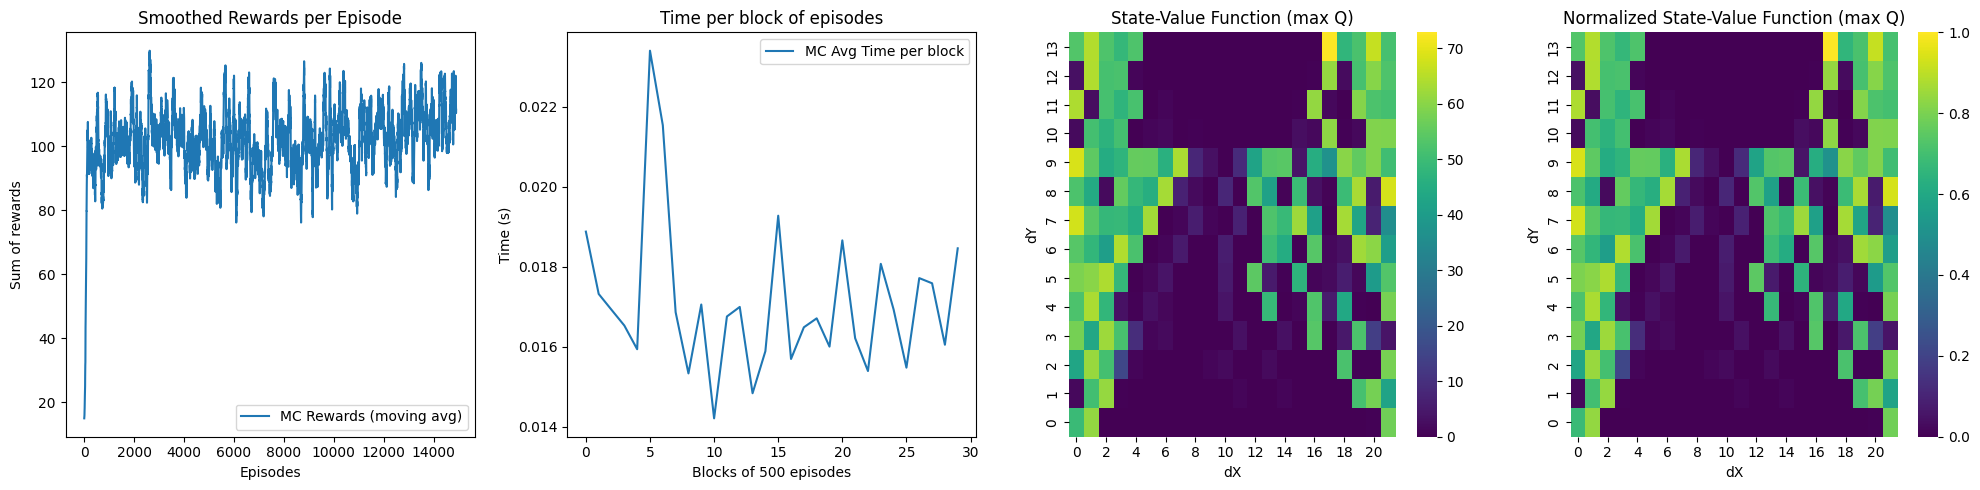

In [ ]:
import text_flappy_bird_gym
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
agent_info = {"num_actions": 2, "num_states_x": 14, "num_states_y": 22, "epsilon": 0.85, "epsilon_min" : 1e-7, "lambda":0.8, "epsilon_decay" : 0.999, "step_size": 0.05, "discount": 0.99, "seed":1}
train(agent_info, MonteCarloAgent, "MC", env, name = 'MC_agent_20000_steps')

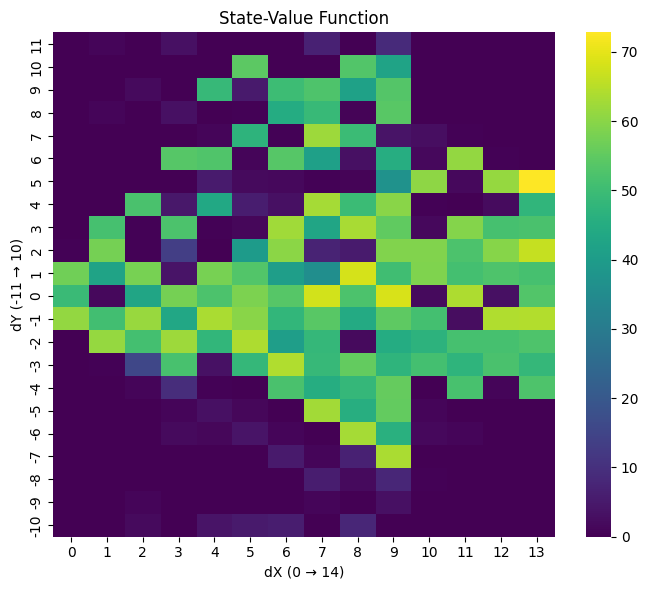

In [ ]:
agent_info = {"num_actions": 2, "num_states_x": 14, "num_states_y": 22,  "epsilon": 0.0, "epsilon_min" : 5e-3, "lambda":0.8, "epsilon_decay" : 0.99,'step_size': 0.4151478230492108, "discount": 0.99, "seed":1}
MC_agent = load_agent_from_q('/content/MC_agent_20000_steps_Q.pt', MonteCarloAgent, agent_info)
plot_state_value(MC_agent, normalize=False)

# Fine-tuning avec optuna

I am going to do a first large research to print out the contribution of each hyperparameter thanks to Optuna. Then I will do a more precise study only on the hyperparameters with an high contribution.

## Sarsa

### First study

In [ ]:


def train_sarsa(env, config, num_episodes=4000):
    agent = SarsaLambdaAgent()
    agent.agent_init(config)
    avg_reward = 0
    for _ in range(num_episodes):
        state = env.reset()[0]
        action = agent.agent_start(state)
        done = False
        total_reward = 0
        while not done:
            obs, reward, done, *_ = env.step(action)
            if not done:
                action = agent.agent_step(reward, obs)
            else:
                agent.agent_end(reward)
            total_reward += reward
        avg_reward += total_reward
    return avg_reward / num_episodes


def objective(trial):
    epsilon = trial.suggest_float("epsilon", 0.3, 0.9)
    epsilon_min = trial.suggest_float("epsilon_min", 1e-7, 1e-2)
    alpha = trial.suggest_float("step_size", 0.01, 0.5)
    decay = trial.suggest_float('epsilon_decay', 0.5, 0.999)
    lmbda = trial.suggest_float("lambda", 0.0, 1.0)

    config = {
        "num_actions": 2, "num_states_x": 14, "num_states_y": 22,
        "epsilon": epsilon,
        "step_size": alpha,
        "epsilon_decay": decay,
        "epsilon_min": epsilon_min,
        "discount": 0.99,
        "lambda": lmbda,
        "seed": 1
    }

    avg_reward = train_sarsa(env, config)
    return avg_reward


env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
print(f"Value: {study.best_trial.value}")
print("Params:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

print("\nStudy statistics:")
print("  Number of finished trials:", len(study.trials))

print("\nTrials summary:")
for trial in study.trials:
    print(f"Trial {trial.number}: Value={trial.value}, Params={trial.params}")

try:
    import optuna.visualization as vis
    vis.plot_param_importances(study).show()
    vis.plot_optimization_history(study).show()
except Exception as e:
    print("Visualization failed:", e)

[I 2025-03-23 13:46:11,498] A new study created in memory with name: no-name-57e10fcb-3abc-452b-9574-742e0d20a2f9
[I 2025-03-23 13:46:32,350] Trial 0 finished with value: 15.81575 and parameters: {'epsilon': 0.30168655910478254, 'epsilon_min': 0.0017406648237330154, 'step_size': 0.45556280365460405, 'epsilon_decay': 0.677727690577841, 'lambda': 0.5344573258592459}. Best is trial 0 with value: 15.81575.
[I 2025-03-23 13:46:59,657] Trial 1 finished with value: 34.016 and parameters: {'epsilon': 0.5720825669747833, 'epsilon_min': 0.008212879559012629, 'step_size': 0.4921662406302173, 'epsilon_decay': 0.9625458344724374, 'lambda': 0.053281915704776917}. Best is trial 1 with value: 34.016.
[I 2025-03-23 13:47:11,742] Trial 2 finished with value: 15.15375 and parameters: {'epsilon': 0.3436495341940228, 'epsilon_min': 0.003966641469198322, 'step_size': 0.19404266409044482, 'epsilon_decay': 0.8024067604430172, 'lambda': 0.6086530568599607}. Best is trial 1 with value: 34.016.
[I 2025-03-23 13:

Best trial:
Value: 401.863
Params:
  epsilon: 0.31598439721070753
  epsilon_min: 0.006143223614623013
  step_size: 0.302749194457011
  epsilon_decay: 0.672398334777828
  lambda: 0.8127492294218093

Study statistics:
  Number of finished trials: 100

Trials summary:
Trial 0: Value=15.81575, Params={'epsilon': 0.30168655910478254, 'epsilon_min': 0.0017406648237330154, 'step_size': 0.45556280365460405, 'epsilon_decay': 0.677727690577841, 'lambda': 0.5344573258592459}
Trial 1: Value=34.016, Params={'epsilon': 0.5720825669747833, 'epsilon_min': 0.008212879559012629, 'step_size': 0.4921662406302173, 'epsilon_decay': 0.9625458344724374, 'lambda': 0.053281915704776917}
Trial 2: Value=15.15375, Params={'epsilon': 0.3436495341940228, 'epsilon_min': 0.003966641469198322, 'step_size': 0.19404266409044482, 'epsilon_decay': 0.8024067604430172, 'lambda': 0.6086530568599607}
Trial 3: Value=11.74125, Params={'epsilon': 0.8800720720514992, 'epsilon_min': 0.0022875029258968204, 'step_size': 0.35255928606

### Second study

In [ ]:


def train_sarsa(env, config, num_episodes=4000):
    agent = SarsaLambdaAgent()
    agent.agent_init(config)
    avg_reward = 0
    for _ in range(num_episodes):
        state = env.reset()[0]
        action = agent.agent_start(state)
        done = False
        total_reward = 0
        while not done:
            obs, reward, done, *_ = env.step(action)
            if not done:
                action = agent.agent_step(reward, obs)
            else:
                agent.agent_end(reward)
            total_reward += reward
        avg_reward += total_reward
    return avg_reward / num_episodes


def objective(trial):
    epsilon = trial.suggest_float("epsilon", 0.3, 0.8)
    #epsilon_min = trial.suggest_float("epsilon_min", 1e-7, 1e-2)
    alpha = trial.suggest_float("step_size", 0.01, 0.5)
    # decay = trial.suggest_float('epsilon_decay', 0.5, 0.999)
    # lmbda = trial.suggest_float("lambda", 0.0, 1.0)

    config = {
        "num_actions": 2, "num_states_x": 14, "num_states_y": 22,
        "epsilon": epsilon,
        "step_size": alpha,
        "epsilon_decay": 0.99,
        "epsilon_min": 5e-3,
        "discount": 0.99,
        "lambda": 0.8,
        "seed": 1
    }

    avg_reward = train_sarsa(env, config)
    return avg_reward


env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
print(f"Value: {study.best_trial.value}")
print("Params:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

print("\nStudy statistics:")
print("  Number of finished trials:", len(study.trials))

print("\nTrials summary:")
for trial in study.trials:
    print(f"Trial {trial.number}: Value={trial.value}, Params={trial.params}")

try:
    import optuna.visualization as vis
    vis.plot_param_importances(study).show()
    vis.plot_optimization_history(study).show()
except Exception as e:
    print("Visualization failed:", e)

[I 2025-03-24 07:45:35,423] A new study created in memory with name: no-name-0e73b1e4-44fa-45e3-8721-7d299f885133
[I 2025-03-24 07:45:41,529] Trial 0 finished with value: 11.2835 and parameters: {'epsilon': 0.33579911258915845, 'step_size': 0.15200653367776124}. Best is trial 0 with value: 11.2835.
[I 2025-03-24 07:45:52,045] Trial 1 finished with value: 17.6535 and parameters: {'epsilon': 0.325085270326763, 'step_size': 0.12995368310733618}. Best is trial 1 with value: 17.6535.
[I 2025-03-24 07:46:20,273] Trial 2 finished with value: 52.1725 and parameters: {'epsilon': 0.5687858596230331, 'step_size': 0.23542152090628246}. Best is trial 2 with value: 52.1725.
[I 2025-03-24 07:46:29,281] Trial 3 finished with value: 17.0475 and parameters: {'epsilon': 0.5622940047809647, 'step_size': 0.023349645135835706}. Best is trial 2 with value: 52.1725.
[I 2025-03-24 07:46:40,981] Trial 4 finished with value: 22.32775 and parameters: {'epsilon': 0.5964065150149592, 'step_size': 0.3390612262502477

Best trial:
Value: 524.49525
Params:
  epsilon: 0.35089488205885944
  step_size: 0.4151478230492108

Study statistics:
  Number of finished trials: 100

Trials summary:
Trial 0: Value=11.2835, Params={'epsilon': 0.33579911258915845, 'step_size': 0.15200653367776124}
Trial 1: Value=17.6535, Params={'epsilon': 0.325085270326763, 'step_size': 0.12995368310733618}
Trial 2: Value=52.1725, Params={'epsilon': 0.5687858596230331, 'step_size': 0.23542152090628246}
Trial 3: Value=17.0475, Params={'epsilon': 0.5622940047809647, 'step_size': 0.023349645135835706}
Trial 4: Value=22.32775, Params={'epsilon': 0.5964065150149592, 'step_size': 0.3390612262502477}
Trial 5: Value=30.49125, Params={'epsilon': 0.49033519366809, 'step_size': 0.07287308699123811}
Trial 6: Value=21.12975, Params={'epsilon': 0.7435363546966474, 'step_size': 0.09218422335147289}
Trial 7: Value=58.29225, Params={'epsilon': 0.5079214877744985, 'step_size': 0.4607799097558573}
Trial 8: Value=11.5805, Params={'epsilon': 0.630799201

### Fine-tuned agent

Text Flappy Bird!
Score: 0
----------------------
[      @|         |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[       |         |  ]
[       |         |  ]
[       |            ]
[       |            ]
[       |            ]
[       |            ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=1,dy=-3)
Total reward from demo: 13


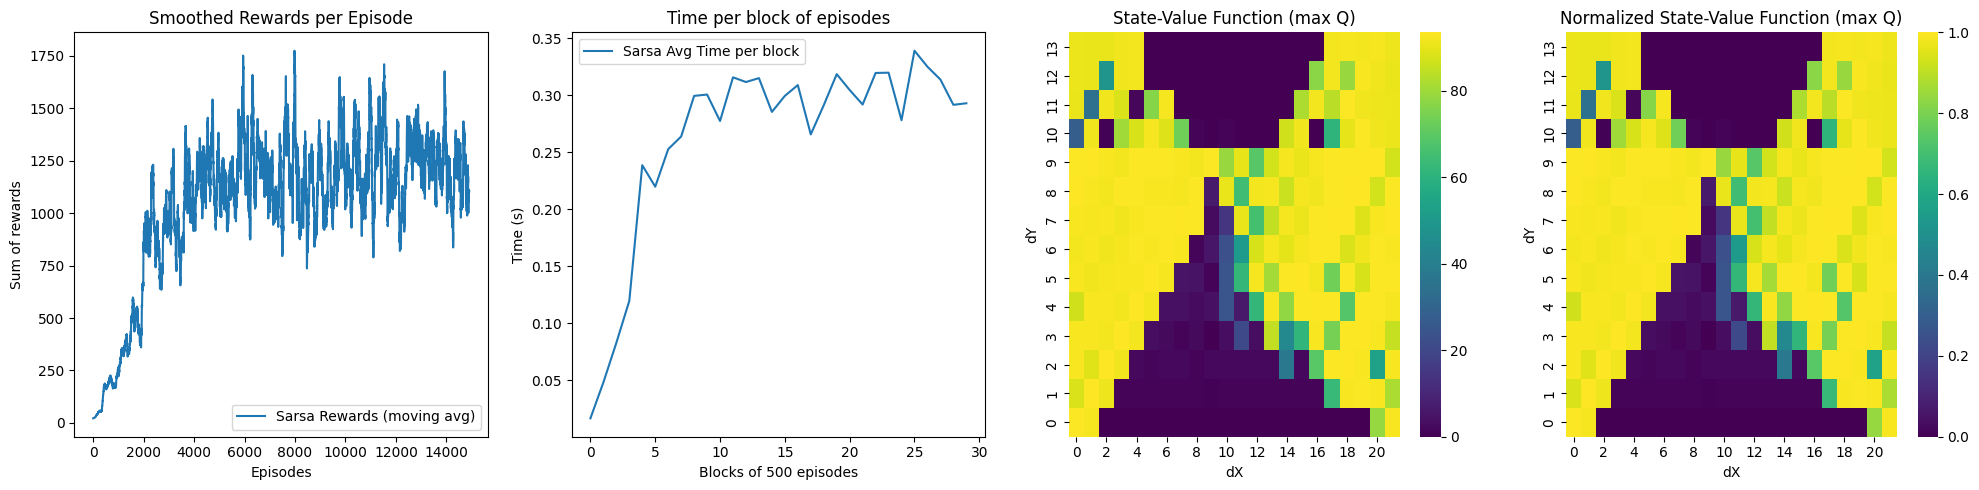

In [ ]:
import text_flappy_bird_gym
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
agent_info = {"num_actions": 2, "num_states_x": 14, "num_states_y": 22, "epsilon": 0.35089488205885944, "epsilon_min" : 5e-3, "lambda":0.8, "epsilon_decay" : 0.99,'step_size': 0.4151478230492108, "discount": 0.99, "seed":1}
best_agent_sarsa = train(agent_info, SarsaLambdaAgent, "Sarsa", env, save = True, N_ep = 15000,  name = 'fine_tuned_sarsa_agent_15000_steps')


Adding more steps

Text Flappy Bird!
Score: 0
----------------------
[      @|         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |            ]
[       |            ]
[       |            ]
[       |            ]
[       |         |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=1,dy=-12)
Total reward from demo: 13


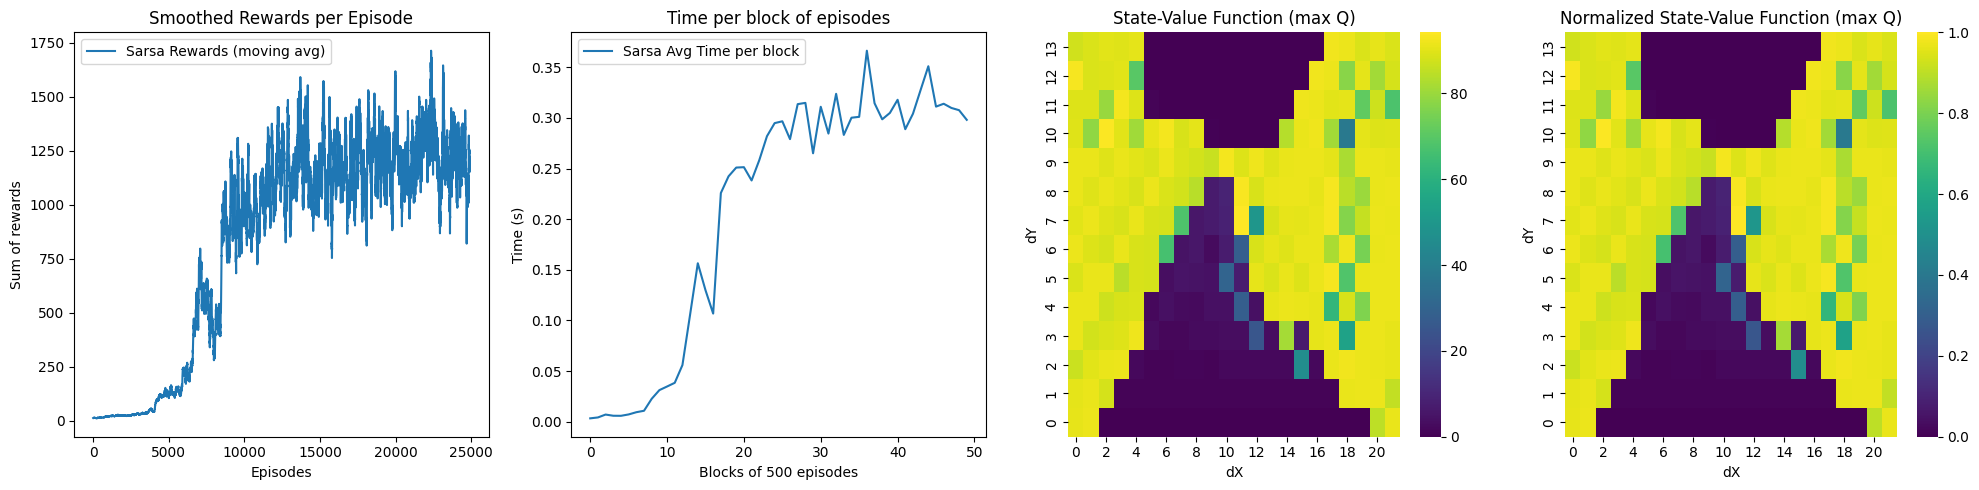

In [ ]:
import text_flappy_bird_gym
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
agent_info = {"num_actions": 2, "num_states_x": 14, "num_states_y": 22, "epsilon": 0.35089488205885944, "epsilon_min" : 5e-3, "lambda":0.8, "epsilon_decay" : 0.99,'step_size': 0.4151478230492108, "discount": 0.99, "seed":1}
best_agent_sarsa_bis = train(agent_info, SarsaLambdaAgent, "Sarsa", env, save = True, N_ep = 25000, name = 'fine_tuned_sarsa_agent_25000_steps')

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
run_demo(best_agent_sarsa_bis, env )

Text Flappy Bird!
Score: 497
----------------------
[       |         |  ]
[       |         |  ]
[       |         |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[       |            ]
[      @|            ]
[       |            ]
[       |            ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=1,dy=3)
Total reward from demo: 4983


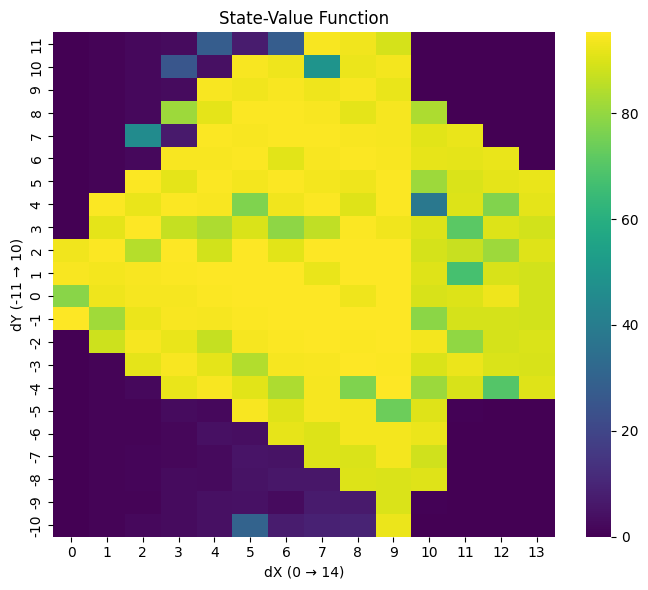

In [ ]:
plot_state_value(best_agent_sarsa_bis, normalize=False)

## Monte Carlo

### First study

In [ ]:
def train_MC(env, config, num_episodes=4000):
    agent = MonteCarloAgent()
    agent.agent_init(config)
    avg_reward = 0
    for _ in range(num_episodes):
        state = env.reset()[0]
        action = agent.agent_start(state)
        done = False
        total_reward = 0
        while not done:
            obs, reward, done, *_ = env.step(action)
            if not done:
                action = agent.agent_step(reward, obs)
            else:
                agent.agent_end(reward)
            total_reward += reward
        avg_reward += total_reward
    return avg_reward / num_episodes

def objective(trial):
    epsilon = trial.suggest_float("epsilon", 0.001, 0.9)
    epsilon_min = trial.suggest_float("epsilon_min", 1e-7, 1e-2)
    alpha = trial.suggest_float("step_size", 0.01, 0.5)
    decay = trial.suggest_float('epsilon_decay', 0.5, 0.999)

    config = {
        "num_actions": 2, "num_states_x": 14, "num_states_y": 22,
        "epsilon": epsilon,
        "step_size": alpha,
        "epsilon_decay": decay,
        "epsilon_min": epsilon_min,
        "discount": 0.99,
        "seed": 1
    }

    avg_reward = train_MC(env, config)
    return avg_reward

env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
print(f"Value: {study.best_trial.value}")
print("Params:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

print("\nStudy statistics:")
print("  Number of finished trials:", len(study.trials))

print("\nTrials summary:")
for trial in study.trials:
    print(f"Trial {trial.number}: Value={trial.value}, Params={trial.params}")

try:
    import optuna.visualization as vis
    vis.plot_param_importances(study).show()
    vis.plot_optimization_history(study).show()
except Exception as e:
    print("Visualization failed:", e)


[I 2025-03-23 15:06:14,990] A new study created in memory with name: no-name-1aff3e0e-fc61-473b-96fe-1e879023beee
[I 2025-03-23 15:07:27,053] Trial 0 finished with value: 173.199 and parameters: {'epsilon': 0.2110061963382646, 'epsilon_min': 0.008620040668706518, 'step_size': 0.22171750603864543, 'epsilon_decay': 0.7600723322845595}. Best is trial 0 with value: 173.199.
[I 2025-03-23 15:07:41,669] Trial 1 finished with value: 34.639 and parameters: {'epsilon': 0.5414796685749937, 'epsilon_min': 0.002054722344535749, 'step_size': 0.47206769625905803, 'epsilon_decay': 0.6655558425594396}. Best is trial 0 with value: 173.199.
[I 2025-03-23 15:07:51,921] Trial 2 finished with value: 24.384 and parameters: {'epsilon': 0.2200717815956221, 'epsilon_min': 0.008280609984095817, 'step_size': 0.1311772152052169, 'epsilon_decay': 0.937411004337779}. Best is trial 0 with value: 173.199.
[I 2025-03-23 15:07:56,996] Trial 3 finished with value: 12.8575 and parameters: {'epsilon': 0.842126029865227, '

Best trial:
Value: 303.43225
Params:
  epsilon: 0.6159412622443304
  epsilon_min: 0.004888626259226049
  step_size: 0.42758009430041
  epsilon_decay: 0.8049787402225455

Study statistics:
  Number of finished trials: 100

Trials summary:
Trial 0: Value=173.199, Params={'epsilon': 0.2110061963382646, 'epsilon_min': 0.008620040668706518, 'step_size': 0.22171750603864543, 'epsilon_decay': 0.7600723322845595}
Trial 1: Value=34.639, Params={'epsilon': 0.5414796685749937, 'epsilon_min': 0.002054722344535749, 'step_size': 0.47206769625905803, 'epsilon_decay': 0.6655558425594396}
Trial 2: Value=24.384, Params={'epsilon': 0.2200717815956221, 'epsilon_min': 0.008280609984095817, 'step_size': 0.1311772152052169, 'epsilon_decay': 0.937411004337779}
Trial 3: Value=12.8575, Params={'epsilon': 0.842126029865227, 'epsilon_min': 0.0003784743688847566, 'step_size': 0.46621961140060714, 'epsilon_decay': 0.7590645683114287}
Trial 4: Value=18.33, Params={'epsilon': 0.35163733513277845, 'epsilon_min': 0.001

### Second study

In [ ]:
def train_MC(env, config, num_episodes=4000):
    agent = MonteCarloAgent()
    agent.agent_init(config)
    avg_reward = 0
    for _ in range(num_episodes):
        state = env.reset()[0]
        action = agent.agent_start(state)
        done = False
        total_reward = 0
        while not done:
            obs, reward, done, *_ = env.step(action)
            if not done:
                action = agent.agent_step(reward, obs)
            else:
                agent.agent_end(reward)
            total_reward += reward
        avg_reward += total_reward
    return avg_reward / num_episodes

def objective(trial):
    #epsilon = trial.suggest_float("epsilon", 0.001, 0.9)
    epsilon_min = trial.suggest_float("epsilon_min", 1e-4, 1e-2)
    alpha = trial.suggest_float("step_size", 0.01, 0.5)
    # decay = trial.suggest_float('epsilon_decay', 0.5, 0.999)

    config = {
        "num_actions": 2, "num_states_x": 14, "num_states_y": 22,
        'epsilon': 0.6159412622443304, 'epsilon_min': epsilon_min, 'step_size': alpha, 'epsilon_decay': 0.8049787402225455,
        "discount": 0.99,
        "seed": 1
    }

    avg_reward = train_MC(env, config)
    return avg_reward

env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
print(f"Value: {study.best_trial.value}")
print("Params:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

print("\nStudy statistics:")
print("  Number of finished trials:", len(study.trials))

print("\nTrials summary:")
for trial in study.trials:
    print(f"Trial {trial.number}: Value={trial.value}, Params={trial.params}")

try:
    import optuna.visualization as vis
    vis.plot_param_importances(study).show()
    vis.plot_optimization_history(study).show()
except Exception as e:
    print("Visualization failed:", e)


[I 2025-03-24 09:02:42,456] A new study created in memory with name: no-name-7b7d68c7-c1d5-4ac1-8a8a-fd361c49d738
[I 2025-03-24 09:02:48,726] Trial 0 finished with value: 21.9015 and parameters: {'epsilon_min': 0.006742677966318534, 'step_size': 0.1316347058200264}. Best is trial 0 with value: 21.9015.
[I 2025-03-24 09:03:28,441] Trial 1 finished with value: 136.3755 and parameters: {'epsilon_min': 0.008821236572889775, 'step_size': 0.48697432980667643}. Best is trial 1 with value: 136.3755.
[I 2025-03-24 09:03:31,686] Trial 2 finished with value: 10.84325 and parameters: {'epsilon_min': 0.0034603031762311027, 'step_size': 0.050330229647669464}. Best is trial 1 with value: 136.3755.
[I 2025-03-24 09:03:45,534] Trial 3 finished with value: 47.23375 and parameters: {'epsilon_min': 0.006101712208645978, 'step_size': 0.28938258481331075}. Best is trial 1 with value: 136.3755.
[I 2025-03-24 09:03:49,701] Trial 4 finished with value: 13.28375 and parameters: {'epsilon_min': 0.004674968305970

Best trial:
Value: 276.2895
Params:
  epsilon_min: 0.0072952795896325815
  step_size: 0.47336298449606184

Study statistics:
  Number of finished trials: 100

Trials summary:
Trial 0: Value=21.9015, Params={'epsilon_min': 0.006742677966318534, 'step_size': 0.1316347058200264}
Trial 1: Value=136.3755, Params={'epsilon_min': 0.008821236572889775, 'step_size': 0.48697432980667643}
Trial 2: Value=10.84325, Params={'epsilon_min': 0.0034603031762311027, 'step_size': 0.050330229647669464}
Trial 3: Value=47.23375, Params={'epsilon_min': 0.006101712208645978, 'step_size': 0.28938258481331075}
Trial 4: Value=13.28375, Params={'epsilon_min': 0.004674968305970461, 'step_size': 0.23164834878449225}
Trial 5: Value=31.16625, Params={'epsilon_min': 0.0017671808335608062, 'step_size': 0.4671895603254057}
Trial 6: Value=16.0985, Params={'epsilon_min': 0.0008804213374794625, 'step_size': 0.19182062003407702}
Trial 7: Value=15.13975, Params={'epsilon_min': 0.0029312058981918834, 'step_size': 0.14769763506

### Fine-tuned agent

Text Flappy Bird!
Score: 0
----------------------
[      @|         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |            ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[       |         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=1,dy=-11)
Total reward from demo: 13


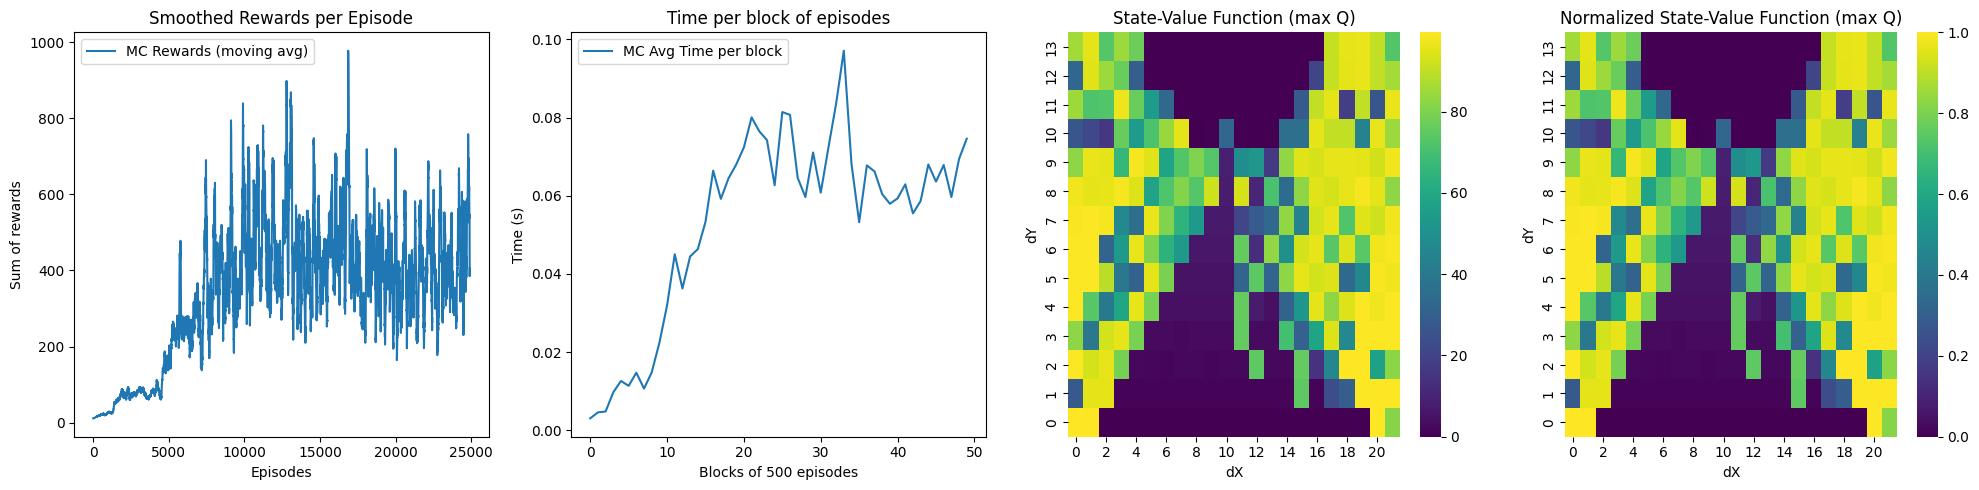

In [ ]:
import text_flappy_bird_gym
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
agent_info = {"num_actions": 2, "num_states_x": 14, "num_states_y": 22,'epsilon': 0.6409587084439001, 'step_size': 0.44598461587266175, "epsilon_min" : 5e-3,  "epsilon_decay" : 0.99, "discount": 0.99, "seed":1}
best_MC_agent = train(agent_info, MonteCarloAgent, "MC", env, save = True, N_ep = 25000, name = 'fine_tuned_MC_agent_25000_steps')

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
run_demo(best_MC_agent, env )

Text Flappy Bird!
Score: 64
----------------------
[       |         |  ]
[      @|         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |            ]
[       |            ]
[       |            ]
[       |            ]
[       |         |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=1,dy=-11)
Total reward from demo: 653


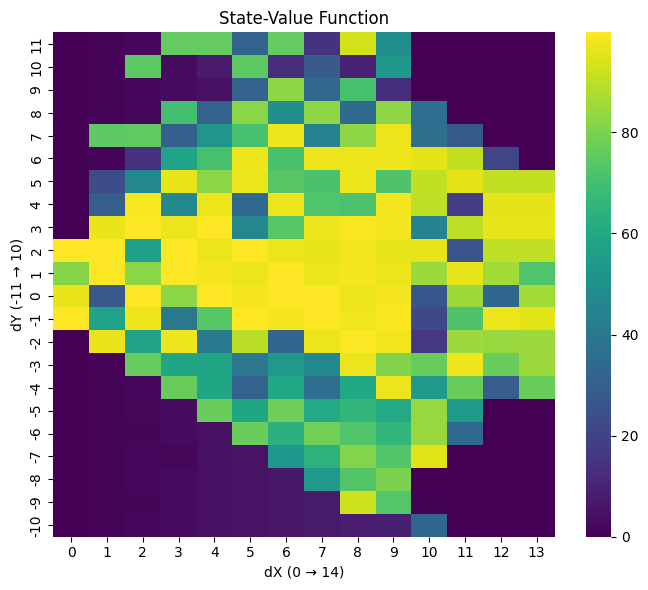

In [ ]:
plot_state_value(best_MC_agent, normalize=False)

# Study of the hyperparameters of the game

In [ ]:
agent_info = {"num_actions": 2, "num_states_x": 14, "num_states_y": 22,  "epsilon": 0.0, "epsilon_min" : 5e-3, "lambda":0.8, "epsilon_decay" : 0.99,'step_size': 0.4151478230492108, "discount": 0.99, "seed":1}
sarsa_agent = load_agent_from_q('/content/fine_tuned_sarsa_agent_25000_steps_Q.pt', SarsaLambdaAgent, agent_info)
MC_agent = load_agent_from_q('/content/fine_tuned_MC_agent_25000_steps_Q.pt', MonteCarloAgent, agent_info)

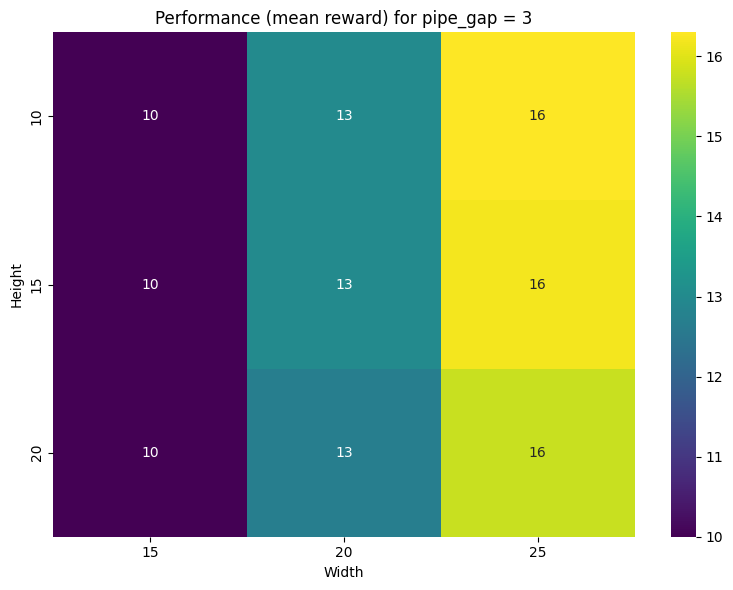

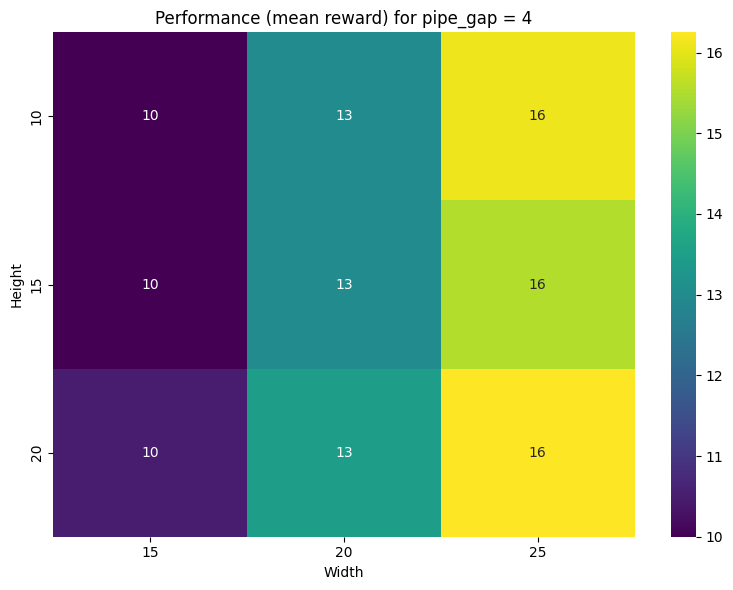

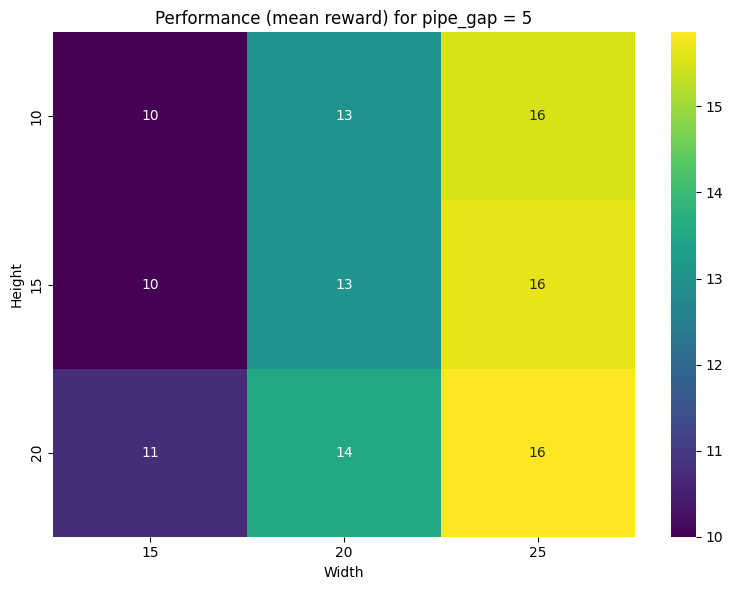

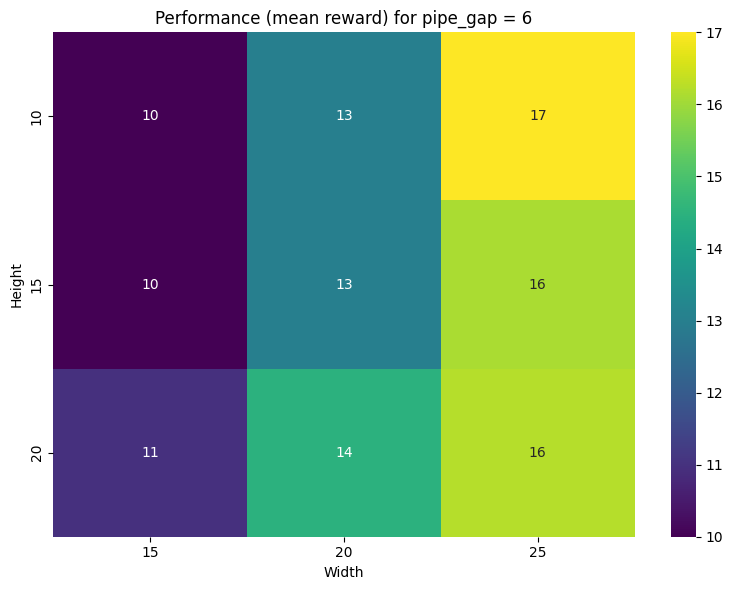

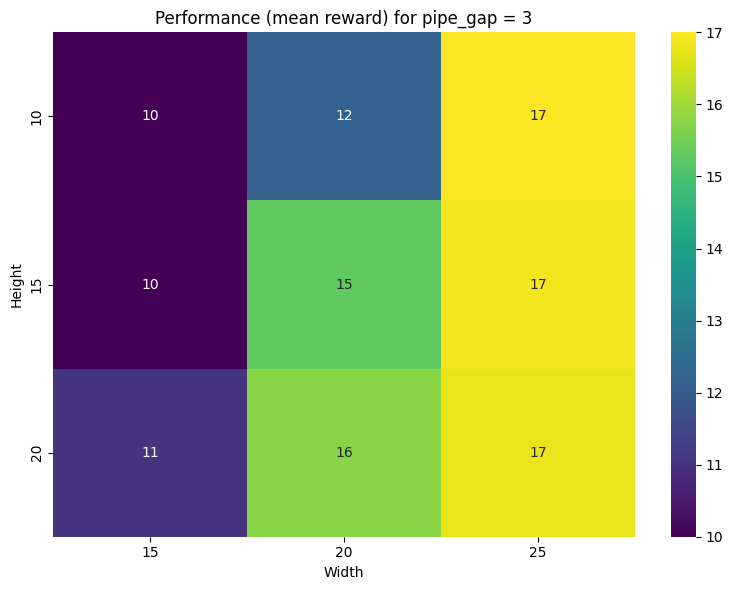

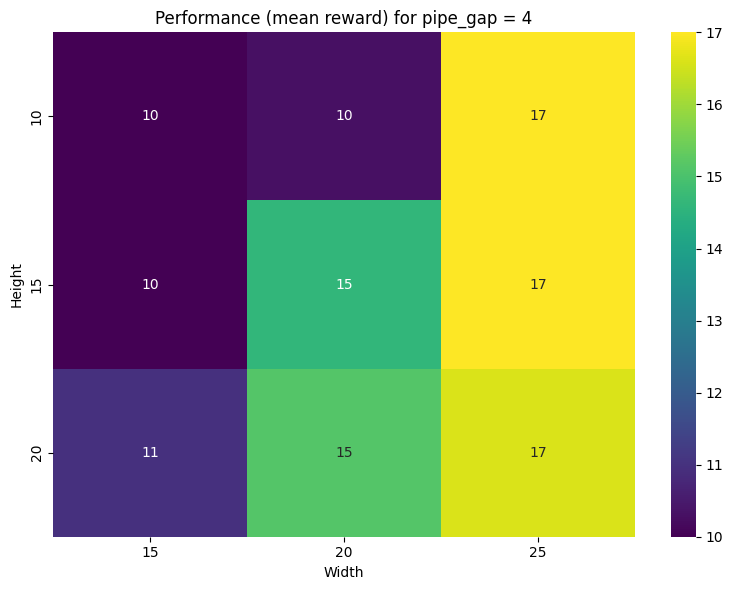

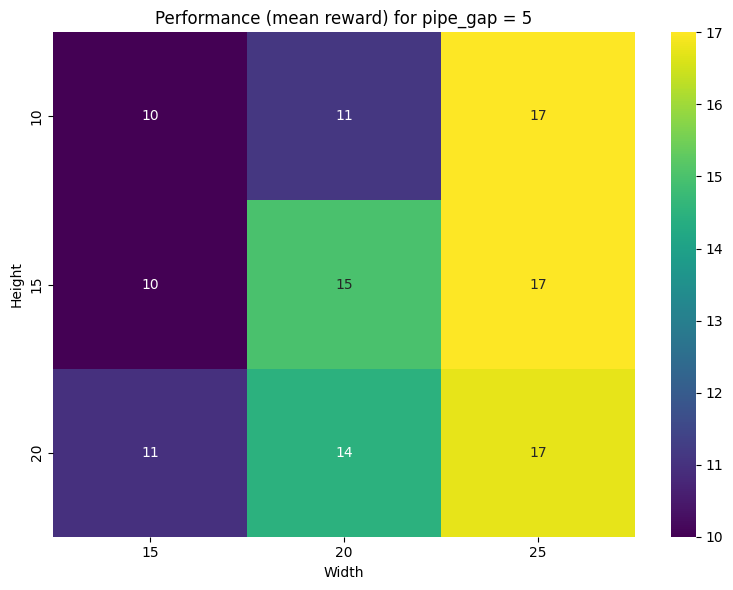

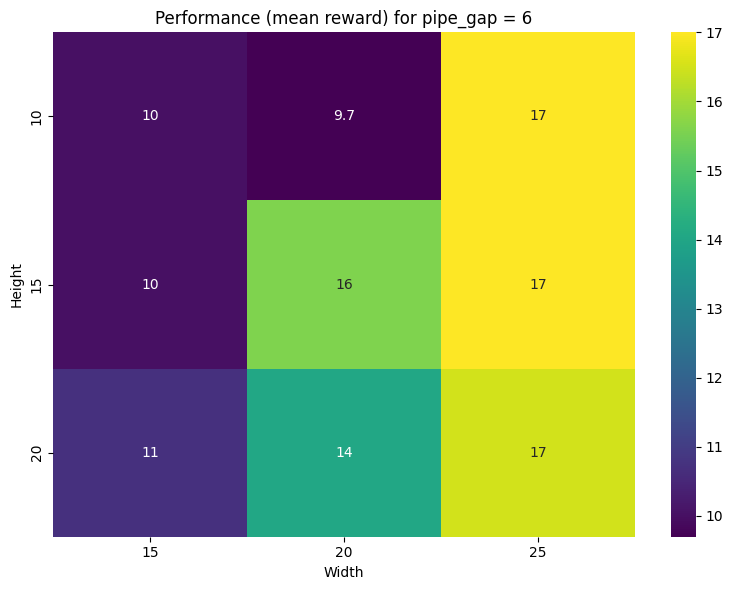

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def make_env(height=15, width=20, pipe_gap=4):
    env = gym.make('TextFlappyBird-v0', height = height, width = width, pipe_gap = pipe_gap)
    return env

def evaluate_agent(agent, env, n_episodes=100, max_steps=1000, render=False):
    rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        action = agent.agent_start(state)

        for _ in range(max_steps):
            if render:
                env.render()
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                agent.agent_end(reward)
                break
            else:
                action = agent.agent_step(reward, next_state)
                state = next_state

        rewards.append(total_reward)
    return np.mean(rewards), np.std(rewards)


def run_generalization_study(agent,
                              pipe_gaps=[3, 4, 5, 6],
                              widths=[15, 20, 25],
                              heights=[10, 15, 20],
                              base_config={"height": 15, "width": 20, "pipe_gap": 4},
                              n_eval=100):
    results = defaultdict(dict)
    for gap in pipe_gaps:
        for w in widths:
            for h in heights:
                # print(f"Testing config: gap={gap}, width={w}, height={h}")
                env = make_env(height=h, width=w, pipe_gap=gap)
                mean_r, std_r = evaluate_agent(agent, env, n_episodes=n_eval)
                results[(gap, w, h)] = (mean_r, std_r)
                env.close()
    return results


def plot_results(results):
    """
    Plot one heatmap per pipe_gap value showing the mean reward
    over (width, height) combinations.
    """

    unique_gaps = sorted(set(k[0] for k in results.keys()))

    for selected_gap in unique_gaps:

        filtered = {k: v for k, v in results.items() if k[0] == selected_gap}

        heights = sorted(set(k[2] for k in filtered))
        widths = sorted(set(k[1] for k in filtered))

        heatmap = np.zeros((len(heights), len(widths)))

        for (gap, w, h), (mean_r, _) in filtered.items():
            i = heights.index(h)
            j = widths.index(w)
            heatmap[i, j] = mean_r

        plt.figure(figsize=(8, 6))
        sns.heatmap(heatmap, annot=True, xticklabels=widths, yticklabels=heights, cmap="viridis")
        plt.title(f"Performance (mean reward) for pipe_gap = {selected_gap}")
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.tight_layout()
        plt.show()




# set up for testing without learning (eg: updating weights)

sarsa_agent.freeze = True
sarsa_agent.diff_env  = True
MC_agent.freeze = True
MC_agent.diff_env = True


# Sarsa agent
results = run_generalization_study(sarsa_agent)
plot_results(results)

#MC agent
results = run_generalization_study(MC_agent)
plot_results(results)
